# ADS 509 Module 3: Group Comparison 

The task of comparing two groups of text is fundamental to textual analysis. There are innumerable applications: survey respondents from different segments of customers, speeches by different political parties, words used in Tweets by different constituencies, etc. In this assignment you will build code to effect comparisons between groups of text data, using the ideas learned in reading and lecture.

This assignment asks you to analyze the lyrics for the two artists you selected in Module 1 and the Twitter descriptions pulled for Robyn and Cher. If the results from that pull were not to your liking, you are welcome to use the zipped data from the “Assignment Materials” section. Specifically, you are asked to do the following: 

* Read in the data, normalize the text, and tokenize it. When you tokenize your Twitter descriptions, keep hashtags and emojis in your token set. 
* Calculate descriptive statistics on the two sets of lyrics and compare the results. 
* For each of the four corpora, find the words that are unique to that corpus. 
* Build word clouds for all four corpora. 

Each one of the analyses has a section dedicated to it below. Before beginning the analysis there is a section for you to read in the data and do your cleaning (tokenization and normalization). 


## General Assignment Instructions

These instructions are included in every assignment, to remind you of the coding standards for the class. Feel free to delete this cell after reading it. 

One sign of mature code is conforming to a style guide. We recommend the [Google Python Style Guide](https://google.github.io/styleguide/pyguide.html). If you use a different style guide, please include a cell with a link. 

Your code should be relatively easy-to-read, sensibly commented, and clean. Writing code is a messy process, so please be sure to edit your final submission. Remove any cells that are not needed or parts of cells that contain unnecessary code. Remove inessential `import` statements and make sure that all such statements are moved into the designated cell. 

Make use of non-code cells for written commentary. These cells should be grammatical and clearly written. In some of these cells you will have questions to answer. The questions will be marked by a "Q:" and will have a corresponding "A:" spot for you. *Make sure to answer every question marked with a `Q:` for full credit.* 


In [1]:
import os
import re
import emoji
import pandas as pd

from collections import Counter, defaultdict
from nltk.corpus import stopwords
from string import punctuation
from wordcloud import WordCloud 

from sklearn.feature_extraction.text import TfidfTransformer, CountVectorizer


In [ ]:
# Use this space for any additional import statements you need



In [2]:
# Place any addtional functions or constants you need here. 

# Some punctuation variations
punctuation = set(punctuation) # speeds up comparison
tw_punct = punctuation - {"#"}

# Stopwords
sw = stopwords.words("english")

# Two useful regex
whitespace_pattern = re.compile(r"\s+")
hashtag_pattern = re.compile(r"^#[0-9a-zA-Z]+")

# It's handy to have a full set of emojis
all_language_emojis = set()

for country in emoji.EMOJI_DATA : 
    for em in emoji.EMOJI_DATA[country] : 
        all_language_emojis.add(em)

# and now our functions
def descriptive_stats(tokens, num_tokens = 5, verbose=True) :
    """
        Given a list of tokens, print number of tokens, number of unique tokens, 
        number of characters, lexical diversity, and num_tokens most common
        tokens. Return a list of 
    """
    # Place your Module 2 solution here
    num_tokens = len(tokens)
    num_unique_tokens = len(set(tokens))
    if num_tokens > 0:
        lexical_diversity = num_unique_tokens/num_tokens
    else: lexical_diversity = 0
    num_characters = sum(len(token) for token in tokens)
    
    count = Counter(tokens)
    top_10 = count.most_common(10)

    return([num_tokens, num_unique_tokens,
            lexical_diversity,
            num_characters, top_10])


    
def contains_emoji(s):
    
    s = str(s)
    emojis = [ch for ch in s if emoji.is_emoji(ch)]

    return(len(emojis) > 0)


def remove_stop(tokens) :
    # modify this function to remove stopwords
    tokens = [word for word in tokens if word not in sw]
    return(tokens)
 
def remove_punctuation(text, punct_set=tw_punct) : 
    return("".join([ch for ch in text if ch not in punct_set]))

def tokenize(text) : 
    """ Splitting on whitespace rather than the book's tokenize function. That 
        function will drop tokens like '#hashtag' or '2A', which we need for Twitter. """
    # Convert to lowercase and split into words
    # modify this function to return tokens
    words = str(text).lower().split()
    return(words)

def prepare(text, pipeline) : 
    tokens = str(text)
    
    for transform in pipeline : 
        tokens = transform(tokens)
        
    return(tokens)

def clean(data, col, sw):
    text = ' '.join(data[col])
    # Remove punctuation
    text = re.sub(re.escape(str(tw_punct)), '', text)
    # Convert to lowercase and split into words
    words = str(text).lower().split()
    # Remove stopwords
    cleaned_tokens = [word for word in words if word not in sw]
    return cleaned_tokens

def tw_clean(data, artist, sw):
    token = []
    data_t = data[data['artist']==artist]
    data_t = data_t.dropna(subset = ['description'])

    for index, row in data_t.iterrows():
        text = str(row['description']) 
        token.append(text)
    
    text = ' '.join(token)
    text = re.sub(re.escape(str(tw_punct)), '', text)
    words = str(text).lower().split()
    cleaned_tokens = [word for word in words if word not in sw]
    return cleaned_tokens

def sort(data, sort_col, comp_col):
    data = data[data[sort_col] > data[comp_col]]
    data = data.sort_values(by=sort_col, ascending=False).head(10)
    return data[['token', sort_col, comp_col]]

## Data Ingestion

Use this section to ingest your data into the data structures you plan to use. Typically this will be a dictionary or a pandas DataFrame.

In [3]:
# Feel free to use the below cells as an example or read in the data in a way you prefer

data_location = "/Users/mtc/ADS/ADS 509/M1 Results/" # change to your location if it is not in the same directory as your notebook
twitter_folder = "twitter/"
lyrics_folder = "lyrics/"

artist_files = {'cher':'cher_followers_data.txt',
                'robyn':'robynkonichiwa_followers_data.txt'}


In [4]:
twitter_data = pd.read_csv(data_location + twitter_folder + artist_files['cher'],
                           sep="\t",
                           quoting=3)

twitter_data['artist'] = "cher"

In [5]:
twitter_data_2 = pd.read_csv(data_location + twitter_folder + artist_files['robyn'],
                             sep="\t",
                             quoting=3)
twitter_data_2['artist'] = "robyn"

twitter_data = pd.concat([
    twitter_data,twitter_data_2])
    
del(twitter_data_2)

twitter_data = twitter_data.dropna(subset = ['description'])

In [6]:
# read in the lyrics here
lyrics_data = []

for artist in os.listdir(os.path.join(data_location,lyrics_folder)):
    path = os.path.join(data_location,lyrics_folder, artist)

    for file in os.listdir(path):

        song_path = path + '/' + file

        with open(song_path, 'r', encoding='utf-8') as s:
            lyrics = s.read()
            title = str(re.findall(r'".+"', lyrics))
            title = title[3:-3]
            lyrics_c = re.sub('^".+"', '', lyrics)
            lyrics_data.append({
                'artist' :artist,
                'song_title': title,
                'lyrics': lyrics_c
            })
lyrics_data = pd.DataFrame(lyrics_data)

## Tokenization and Normalization

In this next section, tokenize and normalize your data. We recommend the following cleaning. 

**Lyrics** 

* Remove song titles
* Casefold to lowercase
* Remove stopwords (optional)
* Remove punctuation
* Split on whitespace

Removal of stopwords is up to you. Your descriptive statistic comparison will be different if you include stopwords, though TF-IDF should still find interesting features for you. Note that we remove stopwords before removing punctuation because the stopword set includes punctuation.

**Twitter Descriptions** 

* Casefold to lowercase
* Remove stopwords
* Remove punctuation other than emojis or hashtags
* Split on whitespace

Removing stopwords seems sensible for the Twitter description data. Remember to leave in emojis and hashtags, since you analyze those. 

In [7]:
# apply the `pipeline` techniques from BTAP Ch 1 or 5

my_pipeline = [str.lower, remove_punctuation, tokenize, remove_stop]

lyrics_data["tokens"] = lyrics_data["lyrics"].apply(prepare,pipeline=my_pipeline)
lyrics_data["num_tokens"] = lyrics_data["tokens"].map(len) 

twitter_data["tokens"] = twitter_data["description"].apply(prepare,pipeline=my_pipeline)
twitter_data["num_tokens"] = twitter_data["tokens"].map(len) 

In [8]:
twitter_data['has_emoji'] = twitter_data["description"].apply(contains_emoji)

Let's take a quick look at some descriptions with emojis.

In [9]:
twitter_data[twitter_data.has_emoji].sample(10)[["artist","description","tokens"]]

,artist,description,tokens
1194495,cher,Northeast💨12//Dancer❣️🐾,[northeast💨12dancer❣️🐾]
1304635,cher,Mother of one! Dont knw what Im doing with lif...,"[mother, one, dont, knw, im, life, right, god,..."
837493,cher,The 🌍 needs more kindness.,"[🌍, needs, kindness]"
643147,cher,👵🏻,[👵🏻]
1084398,cher,AZ📍NSFW 18+,"[az📍nsfw, 18]"
2349768,cher,"Life is short. Be kind to family, humans, and ...","[life, short, kind, family, humans, animals, l..."
37278,cher,Holawenas😎,[holawenas😎]
1699602,cher,Mother of 2 amazing boys and married to a lovi...,"[mother, 2, amazing, boys, married, loving, ki..."
2417766,cher,✌️It is the quality of ones convictions that d...,"[✌️it, quality, ones, convictions, determines,..."
1960477,cher,"Wife, mother, ☕️ in no particular order. I’ve ...","[wife, mother, ☕️, particular, order, i’ve, al..."


With the data processed, we can now start work on the assignment questions. 

Q: What is one area of improvement to your tokenization that you could theoretically carry out? (No need to actually do it; let's not make perfect the enemy of good enough.)

A: I think the tokenization could benefit from removing non-English stopwords. At the top of this assignment, the stopwords pulled in were specifically the english ones. If a twitter description or set of lyrics has words that aren't in English, the current code cannot remove stopwords in those instances.

## Calculate descriptive statistics on the two sets of lyrics and compare the results. 


In [10]:
# your code here
r_lyrics = clean(lyrics_data[lyrics_data['artist']=='robyn'], 'lyrics', sw)
c_lyrics = clean(lyrics_data[lyrics_data['artist']=='cher'], 'lyrics', sw)

print('Lyrics- Robyn: Number of Tokens, Unique Tokens, Lexical Diversity, Number of Characters\n' + str(descriptive_stats(r_lyrics, verbose=True)))
print('Lyrics- Cher: Number of Tokens, Unique Tokens, Lexical Diversity, Number of Characters \n' + str(descriptive_stats(c_lyrics, verbose=True)))


Lyrics- Robyn: Number of Tokens, Unique Tokens, Lexical Diversity, Number of Characters
[14602, 2643, 0.18100260238323518, 73854, [('know', 297), ('love', 243), ('got', 240), ('like', 223), ('baby', 174), ('never', 148), ('dance', 143), ('get', 138), ('beat', 137), ('killing', 136)]]
Lyrics- Cher: Number of Tokens, Unique Tokens, Lexical Diversity, Number of Characters 
[33711, 4592, 0.13621666518347128, 168274, [('love', 893), ('know', 448), ('time', 299), ('see', 286), ('one', 267), ('like', 259), ('come', 248), ('take', 248), ('go', 247), ('never', 246)]]


Q: what observations do you make about these data? 

A: Cher has a higher number of characters, overall tokens, and a higher amount of unique tokens. This would make sense, since Cher's music career is quite long. Robyn's lyrics are more lexically diverse.


## Find tokens uniquely related to a corpus

Typically we would use TF-IDF to find unique tokens in documents. Unfortunately, we either have too few documents (if we view each data source as a single document) or too many (if we view each description as a separate document). In the latter case, our problem will be that descriptions tend to be short, so our matrix would be too sparse to support analysis. 

To avoid these problems, we will create a custom statistic to identify words that are uniquely related to each corpus. The idea is to find words that occur often in one corpus and infrequently in the other(s). Since corpora can be of different lengths, we will focus on the _concentration_ of tokens within a corpus. "Concentration" is simply the count of the token divided by the total corpus length. For instance, if a corpus had length 100,000 and a word appeared 1,000 times, then the concentration would be $\frac{1000}{100000} = 0.01$. If the same token had a concentration of $0.005$ in another corpus, then the concentration ratio would be $\frac{0.01}{0.005} = 2$. Very rare words can easily create infinite ratios, so you will also add a cutoff to your code so that a token must appear at least $n$ times for you to return it. 

An example of these calculations can be found in [this spreadsheet](https://docs.google.com/spreadsheets/d/1P87fkyslJhqXFnfYezNYrDrXp_GS8gwSATsZymv-9ms). Please don't hesitate to ask questions if this is confusing. 

In this section find 10 tokens for each of your four corpora that meet the following criteria: 

1. The token appears at least `n` times in all corpora
1. The tokens are in the top 10 for the highest ratio of appearances in a given corpora vs appearances in other corpora.

You will choose a cutoff for yourself based on the side of the corpus you're working with. If you're working with the Robyn-Cher corpora provided, `n=5` seems to perform reasonably well.

In [11]:
# your code here
def get_count(tokens):
    df = pd.DataFrame.from_records(Counter(tokens).most_common(), columns=['token','count'])
    df['concentration'] = df['count']/sum(df['count'])
    return(df[df['count']> 5])

In [12]:
r_corpus = get_count(r_lyrics)

c_corpus = get_count(c_lyrics)

comp = pd.merge(r_corpus, c_corpus, on=['token'], how='inner' )
comp['ratio_r_over_c'] = comp['concentration_x']/comp['concentration_y']
comp['ratio_c_over_r'] = comp['concentration_y']/comp['concentration_x']

In [13]:
r_twitter = tw_clean(twitter_data, "robyn", sw)
c_twitter = tw_clean(twitter_data, 'cher', sw)

r_tw = get_count(r_twitter)

c_tw = get_count(c_twitter)

comp_t = pd.merge(r_tw, c_tw, on=['token'], how='inner' )
comp_t['ratio_r_over_c'] = comp_t['concentration_x']/comp_t['concentration_y']
comp_t['ratio_c_over_r'] = comp_t['concentration_y']/comp_t['concentration_x']

In [14]:
print('Words with Higher Ratio in Robyn lyrics than Cher Lyrics \n', sort(comp, 'ratio_r_over_c', 'ratio_c_over_r'))
print('Words with Higher Ratio in Cher lyrics than Robyn Lyrics \n', sort(comp, 'ratio_c_over_r', 'ratio_r_over_c'))

Words with Higher Ratio in Robyn lyrics than Cher Lyrics 
        token  ratio_r_over_c  ratio_c_over_r
8       beat       21.085728        0.047425
6      dance       15.006266        0.066639
59      hang       10.100372        0.099006
24      work       10.004178        0.099958
114    stop,        6.596161        0.151603
136    shake        6.541193        0.152877
110    space        5.771641        0.173261
98   [chorus        5.643382        0.177199
162    what,        5.386865        0.185637
141   moment        5.276929        0.189504
Words with Higher Ratio in Cher lyrics than Robyn Lyrics 
        token  ratio_c_over_r  ratio_r_over_c
293     find        9.529352        0.104939
189      man        7.599855        0.131581
261   enough        6.187891        0.161606
217  believe        6.016005        0.166223
186     well        4.174014        0.239578
302     till        3.970564        0.251853
280     hope        3.753987        0.266383
294     many        3.75398

In [15]:
print('Words with Higher Ratio in Robyn Twitter Followers than Cher Followers \n', sort(comp_t, 'ratio_r_over_c', 'ratio_c_over_r'))
print('Words with Higher Ratio in Cher Twitter Followers than Robyn Followers \n', sort(comp_t, 'ratio_c_over_r', 'ratio_r_over_c'))

Words with Higher Ratio in Robyn Twitter Followers than Cher Followers 
              token  ratio_r_over_c  ratio_c_over_r
593       sveriges      202.193632        0.004946
1636     människor      193.884305        0.005158
1417       brinner      192.895099        0.005184
845           följ      186.959866        0.005349
1492        spelar      182.508440        0.005479
958        arbetar      182.238657        0.005487
1090         gärna      175.534540        0.005697
1655      försöker      164.702739        0.006072
1681  kommunikatör      161.735122        0.006183
2117         stora      148.875448        0.006717
Words with Higher Ratio in Cher Twitter Followers than Robyn Followers 
                 token  ratio_c_over_r  ratio_r_over_c
13515     grandmother       35.314531        0.028317
13657            #fbr       28.132241        0.035546
19723        r&b/soul       24.165614        0.041381
14231     hip-hop/rap       23.472417        0.042603
12319  #theresistance  

Q: What are some observations about the top tokens? Do you notice any interesting items on the list? 

A: It looks like the people that follow Cher have more hashtag usage in their twitter description. Robyn's Twitter followers have Swedish in their descriptions, which makes sense, since Robyn is Swedish.

## Build word clouds for all four corpora. 

For building wordclouds, we'll follow exactly the code of the text. The code in this section can be found [here](https://github.com/blueprints-for-text-analytics-python/blueprints-text/blob/master/ch01/First_Insights.ipynb). If you haven't already, you should absolutely clone the repository that accompanies the book. 


In [16]:
from matplotlib import pyplot as plt

def wordcloud(word_freq, title=None, max_words=200, stopwords=None):

    wc = WordCloud(width=800, height=400, 
                   background_color= "black", colormap="Paired", 
                   max_font_size=150, max_words=max_words)
    
    # convert data frame into dict
    if type(word_freq) == pd.Series:
        counter = Counter(word_freq.fillna(0).to_dict())
    else:
        counter = word_freq

    # filter stop words in frequency counter
    if stopwords is not None:
        counter = {token:freq for (token, freq) in counter.items() 
                              if token not in stopwords}
    wc.generate_from_frequencies(counter)
 
    plt.title(title) 

    plt.imshow(wc, interpolation='bilinear')
    plt.axis("off")
    
    
def count_words(df, column='token', preprocess=None, min_freq=2):

    # process tokens and update counter
    def update(doc):
        tokens = doc if preprocess is None else preprocess(doc)
        counter.update(tokens)

    # create counter and run through all data
    counter = Counter()
    df[column].map(update)

    # transform counter into data frame
    freq_df = pd.DataFrame.from_dict(counter, orient='index', columns=['freq'])
    freq_df = freq_df.query('freq >= @min_freq')
    freq_df.index.name = 'token'
    
    return freq_df.sort_values('freq', ascending=False)

In [17]:
robyn_t_counter = count_words(twitter_data[twitter_data['artist']=='robyn'], column = 'tokens')
cher_t_counter = count_words(twitter_data[twitter_data['artist']=='cher'], column = 'tokens')

robyn_l_counter = count_words(lyrics_data[lyrics_data['artist']=='robyn'], column = 'tokens')
cher_l_counter = count_words(lyrics_data[lyrics_data['artist']=='cher'], column = 'tokens')

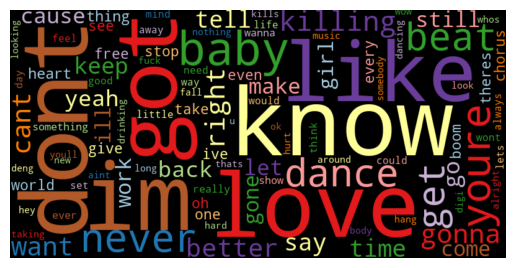

In [18]:
wordcloud(word_freq=robyn_l_counter['freq'], max_words=100)

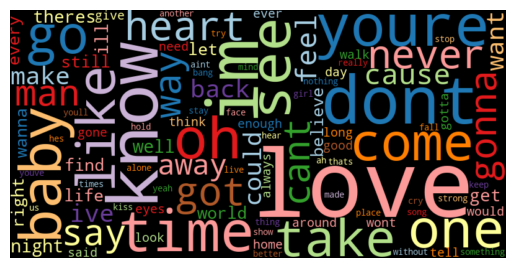

In [19]:
wordcloud(word_freq=cher_l_counter['freq'], max_words=100)

Q: What observations do you have about these (relatively straightforward) wordclouds? 

A: It's easy to compare the largest words to the smallest words, but some of the mid-frequency words are a bit hard to compare to each other. Love is certainly a major theme in the lyrics of both Robyn and Cher.